This tutorial illustrates the 1D example presented in Section 4.1 of :
"Unsupervised learning of time-dependent constitutive material laws with thermodynamics-consistent neural networks in the modified Constitutive Relation Error framework. A. Benady, E. Baranger, L. Chamoin. Under review."

A one-dimension beam, with Young modulus $E$, initial elasticity limit $R_0$, hardening modulus $h$ and length $L=1$, is solicited in tension. 
For the sake of simplicity, this problem is limited to one degree of freedom, in which the displacement is observed and affected by measurement noise. 
Here the behavior is assumed to be known and the only parameter to identify is the hardening modulus $h$.
The potentials are the following: 
\begin{align}
    \psi(\epsilon_e, p) &= \frac{1}{2} E \epsilon^2 + \frac{1}{2} h p^2\\
    \varphi^*(\sigma, R) &= \begin{cases} 0 \mbox{ if }f<0\\
        +\infty \mbox{ if } f= 0
    \end{cases}
\end{align}

with $f= \sigma - (R + R_0)$.

So that, 
\begin{align}
    \sigma &= E \epsilon \\
    R &= hp \mbox{ with } p = \int_0^t||\dot{\epsilon}_p||
\end{align}

and, following the normality rule :
\begin{align}
    \dot\epsilon_p = \dot\lambda\frac{\partial f}{\partial\sigma}
\end{align}

with $\dot\lambda>0$ if $f=0$ and $\dot f =0$.

In [1]:
import torch
import matplotlib.pyplot as plt


In [2]:
E_true = 200e3  # Young modulus
R0_true = 100  # Initial elasticity limit
F_imposed = torch.linspace(0, 140, 8)  # 8 loadings uniformly distributed between 0 and 140

First, we need to create the functions to generate the data needed for training. 
To help the understanding, the Latin method (which will be adapted to perform the Step 1 of the mCRE training) is used to generate the data. 

In [3]:
from utils import integrate_evolution  # Import of the function used to integrate evolutions laws

def generate_data_with_latin(E, R0, h, F_imposed):
    """
    This function simulates the true model in order to generate the data need for the training.
    Input: 
        - E: Young modulus
        - R0: Initial elasticity limit
        - h: Hardening modulus
        - F_imposed: torch.tensor containing all the values of the imposed force at each time step.
    Output:
        - eps_total: total strain (torch.tensor containing the values at each time step)
        - eps_elastic: elastic strain (torch.tensor containing the values at each time step)
        - eps_plastic: plastic strain (torch.tensor containing the values at each time step)
        - sigma: stress (torch.tensor containing the values at each time step)
        - R: isotropic hardening variable (torch.tensor containing the values at each time step)
        - p: cumulated plastic strain (torch.tensor containing the values at each time step)
    """
    
    eps_plastic = torch.zeros_like(F_imposed)
    p, R = torch.zeros_like(F_imposed), torch.zeros_like(F_imposed)

    ## Iteration 0 (elastic initialisation)
    eps_elastic = F_imposed / E 
    eps_total = eps_plastic + eps_elastic


    relative_update = 1
    while relative_update > 1e-4:
        # Local step (integration of evolution laws)
        eps_plastic, eps_elastic, R, p = integrate_evolution(eps_total, eps_plastic, eps_elastic, R, p, R0, h, E)

        # Global step
        d_eps_elastic = (E * eps_elastic - F_imposed) / E
        relative_update = torch.max(torch.abs(d_eps_elastic[1:] / eps_elastic[1:]))
        eps_elastic -= d_eps_elastic
        eps_total = eps_plastic + eps_elastic
        sigma = E * eps_elastic

    return eps_total, eps_elastic, eps_plastic, sigma, R, p

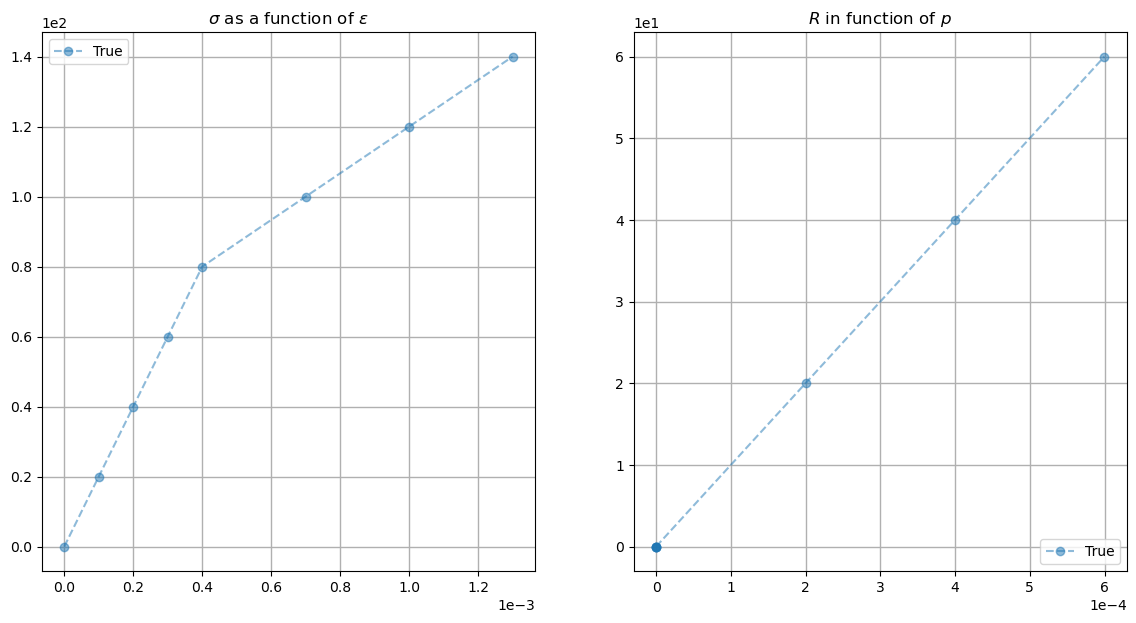

In [4]:
from plot_utils import plot_solution

h_true = 1e5  # True value of the hardening modulus
eps_total_true, eps_elastic_true, eps_plastic_true, sigma_true, R_true, p_true = generate_data_with_latin(E_true, R0_true, h_true, F_imposed)
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
plot_solution(axs, sigma_true, R_true, p_true, eps_total_true, label='True')
plt.show()


Now, let's add some noise on the data.

In [5]:
noise_level = 1e-3

mean = torch.abs(eps_total_true).mean()
noise = torch.normal(std=noise_level * mean * torch.ones_like(eps_total_true), mean=0)
eps_total_true_noisy = eps_total_true + noise

Now, let's minimize the mCRE to update the hardening modulus

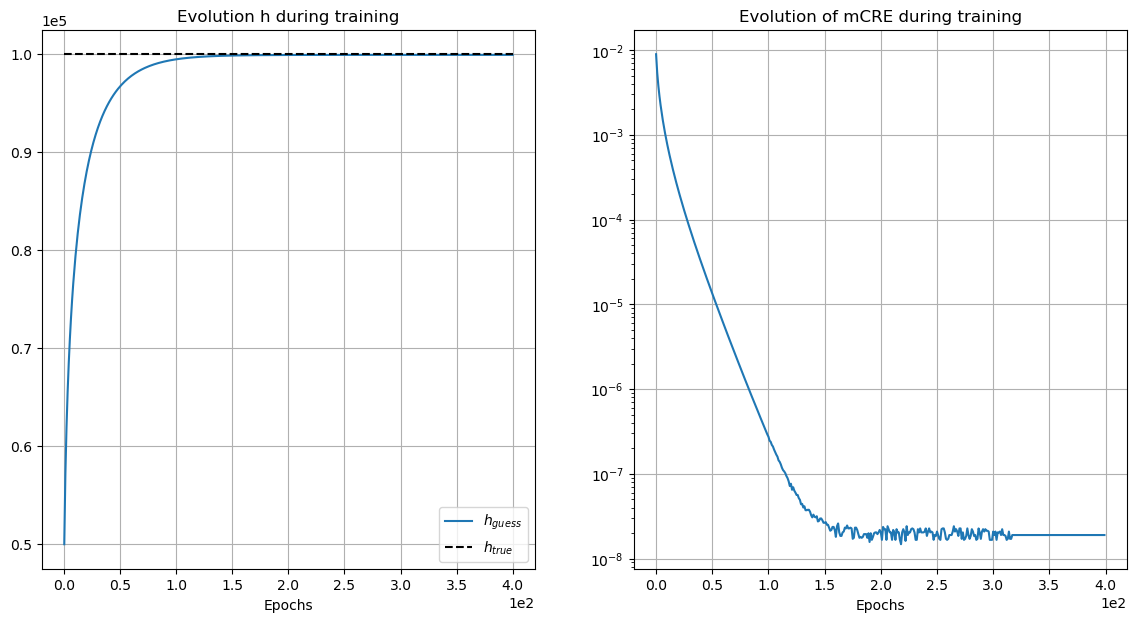

In [6]:
from utils import step_1_mcre_latin, compute_loss, update_h
from plot_utils import plot_evolution_training


# Here we assume that we know the right Young modulus and initial elastic limit
E = E_true  
R0 = R0_true
h_guess = h_true / 2


# Parameters for the optimization (in the full version of the method this parameters are automatically updated)
lr = 1e10
alpha = 1e8
nb_iter_mcre =  400

# List to store the values of loss function and parameters to be updated
list_mcre = []
list_h_guess = [h_guess]

for iter_mcre in range(0, nb_iter_mcre):
    # Step 1 of mCRE: (details in the function)
    eps_total_U, eps_elastic_U, eps_plastic_U, sigma_U, R_U, p_U, eps_total_V, eps_elastic_V, eps_plastic_V, sigma_V, R_V, p_V = step_1_mcre_latin(E, R0, h_guess, F_imposed, eps_total_true_noisy, alpha)
    
    # Computation of the mCRE
    dd_loss, cre_elastic, cre_plastic = compute_loss(eps_total_U, eps_total_true_noisy, E, eps_elastic_U, eps_elastic_V, sigma_V, h_guess, p_U, R_V)
    
    
    list_mcre.append(dd_loss*alpha+cre_plastic)
    
    # Update of parameter h with a gradient descent step
    h_guess = update_h(R_V, p_U, h_guess, lr)
    list_h_guess.append(h_guess)

    
plot_evolution_training(list_h_guess, h_true, list_mcre)

    